# Preferential Bayesian Optimization: Predictive Entropy Search
This notebook demonstrates the use of the Predictive Entropy Search (PES) acquisition function on ordinal (preference) data. 

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  5


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

5 Physical GPUs, 1 Logical GPU


In [4]:
objective = PBO.objectives.six_hump_camel
objective_low = -1.5
objective_high = 1.5
objective_name = "SHC"
acquisition_name = "PES"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name + "v2"

In [5]:
num_runs = 10
num_evals = 30
num_samples = 100
num_choices = 2
input_dims = 2
num_maximizers = 20
num_init_points = 5
num_inducing_init = 5
num_discrete_per_dim = 200 # Discretization of continuous input space

In [6]:
lengthscale = 0.2
lengthscale_prior_alpha = tf.constant(3, dtype=tf.float64)
lengthscale_prior_beta = tf.constant(3, dtype=tf.float64)

In [7]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/PES/results/PBO_PES_SHCv2/  already exists


Plot of the SHC function (global min at at x = [0.0898, -0.7126] and x = [-0.0898, 0.7126]):

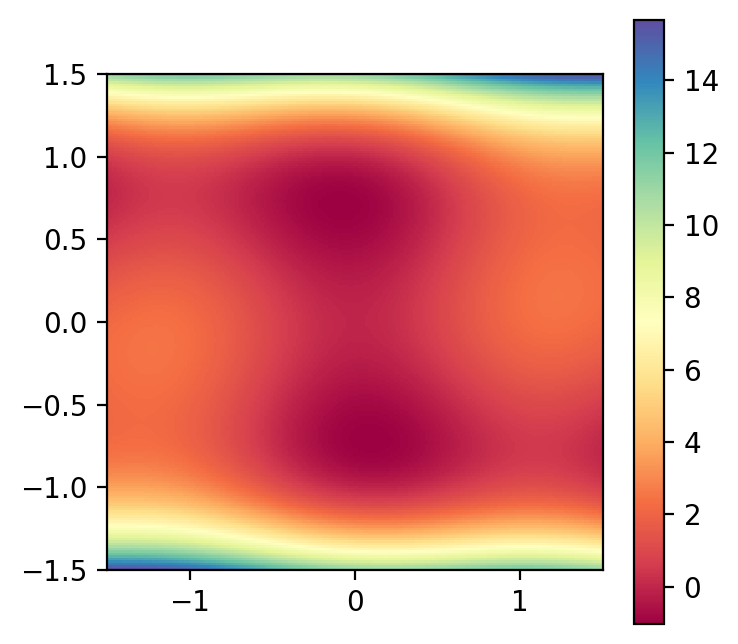

In [8]:
side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
X,Y = np.meshgrid(side,side)
combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
fvals = objective(combs)
preds = tf.transpose(tf.reshape(fvals, [num_discrete_per_dim, num_discrete_per_dim]))
plt.figure(figsize=(4, 4), dpi=200)
plt.imshow(preds, 
           interpolation='nearest', 
           extent=(objective_low, objective_high, objective_low, objective_high), 
           origin='lower', 
           cmap='Spectral')
plt.colorbar()

In [9]:
def plot_gp(model, inducing_points, inputs, title, cmap="Spectral"):

    side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
    combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
    predictions = model.predict_y(combs)
    preds = tf.transpose(tf.reshape(predictions[0], [num_discrete_per_dim, num_discrete_per_dim]))
    variances = tf.transpose(tf.reshape(predictions[1], [num_discrete_per_dim, num_discrete_per_dim]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    fig.set_size_inches(18.5, 6.88)
    fig.set_dpi((200))

    ax1.axis('equal')
    im1 = ax1.imshow(preds, 
                     interpolation='nearest', 
                     extent=(objective_low, objective_high, objective_low, objective_high), 
                     origin='lower', 
                     cmap=cmap)
    ax1.plot(inducing_points[:, 0], inducing_points[:, 1], 'kx', mew=2)
    ax1.plot(inputs[:, 0], inputs[:, 1], 'ko', mew=2, color='w')
    ax1.set_title("Mean")
    ax1.set_xlabel("x0")
    ax1.set_ylabel("x1")
    fig.colorbar(im1, ax=ax1)

    ax2.axis('equal')
    im2 = ax2.imshow(variances, 
                     interpolation='nearest', 
                     extent=(objective_low, objective_high, objective_low, objective_high), 
                     origin='lower', 
                     cmap=cmap)
    ax2.plot(inducing_points[:, 0], inducing_points[:, 1], 'kx', mew=2)
    ax2.plot(inputs[:, 0], inputs[:, 1], 'ko', mew=2, color='w')
    ax2.set_title("Variance")
    ax2.set_xlabel("x0")
    ax2.set_ylabel("x1")
    fig.colorbar(im2, ax=ax2)

    plt.savefig(fname=results_dir + title + ".png")
    plt.show()

In [10]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [11]:
def get_noiseless_observation(X, objective):
    idx = np.argmin(objective(X), axis=-1)
    lst = []
    for i in range(X.shape[0]):
        lst.append(np.expand_dims(X[i][idx[i]], axis=0))
    return lst

In [12]:
def train_and_visualize(X, y, num_inducing, title, inducing_variables):
    lengthscale_prior = tfp.distributions.Gamma(concentration=lengthscale_prior_alpha,
                                               rate=lengthscale_prior_beta)
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k, indifference_threshold = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         lengthscale=lengthscale,
                                                                         lengthscale_prior=None,
                                                                         lengthscale_lower_bound=None,
                                                                         num_steps=3000,
                                                                         indifference_threshold=None,
                                                                         inducing_vars=inducing_variables)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, inputs, title)
    
    return model, inputs, u_mean, inducing_vars

In [13]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the global minimum, the better.

In [14]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [15]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [16]:
np.random.seed(0)
init_points = np.random.uniform(low=objective_low, high=objective_high, size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

In [17]:
init_vals = np.random.uniform(low=objective_low, 
                              high=objective_high, 
                              size=[num_runs, 50, num_choices, input_dims])

In [18]:
a = uniform_grid(input_dims, 10, low=objective_low+0.1, high=objective_high-0.1)
np.random.shuffle(a)
init_vals[0] = np.reshape(a, [-1, 2, 2])

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

Beginning run 0
Indifference_threshold is trainable.
Negative ELBO at step 0: 64.15610832973006 in 1.9557s
<tf.Variable 'u:0' shape=(100, 2) dtype=float64, numpy=
array([[-0.79336481,  1.08277564],
       [ 0.1409837 , -0.12764791],
       [ 1.10529568,  0.18289319],
       [-0.75653062, -1.09685555],
       [-1.39635803, -0.14758956],
       [-1.41277572, -0.46491349],
       [-1.39283375, -1.0990667 ],
       [-0.76691865,  1.39545315],
       [-1.42722474, -1.4229775 ],
       [ 0.4855048 ,  0.79463341],
       [ 1.09767448, -1.07990146],
       [ 0.15601595, -0.7701598 ],
       [ 0.17617747, -1.09472522],
       [ 0.15465254,  0.76490022],
       [ 1.41705492,  0.77392608],
       [-1.3603028 ,  1.09784271],
       [ 0.78167611,  1.38966299],
       [ 0.76716635, -0.77878677],
       [ 0.49618417, -1.08898335],
       [ 0.75576488,  0.47087797],
       [-0.16407296, -1.07199797],
       [-0.17128173, -0.78376167],
       [ 0.45734134, -0.52243828],
       [-1.39337374,  1.40100363

Negative ELBO at step 500: 34.322055423519 in 637.0690s
<tf.Variable 'u:0' shape=(100, 2) dtype=float64, numpy=
array([[-0.77559387,  1.09846829],
       [ 0.1394665 , -0.15371937],
       [ 1.10519119,  0.16265119],
       [-0.75723948, -1.12076208],
       [-1.42556362, -0.14518024],
       [-1.46222113, -0.47779149],
       [-1.42038891, -1.09043413],
       [-0.79176096,  1.44396228],
       [-1.47200063, -1.41162046],
       [ 0.48896294,  0.81537826],
       [ 1.10366415, -1.09332753],
       [ 0.13303505, -0.80485032],
       [ 0.19741421, -1.09886539],
       [ 0.1627831 ,  0.77310629],
       [ 1.48030923,  0.80021037],
       [-1.38932456,  1.1010179 ],
       [ 0.79648138,  1.42482873],
       [ 0.77228355, -0.76677936],
       [ 0.49850942, -1.12156731],
       [ 0.75260137,  0.45232659],
       [-0.14874506, -1.10379241],
       [-0.16842849, -0.7730866 ],
       [ 0.48897305, -0.49893009],
       [-1.435991  ,  1.40723992],
       [ 1.46708524, -0.16528572],
       [-0.82

Negative ELBO at step 1000: 33.54907590855977 in 637.1901s
<tf.Variable 'u:0' shape=(100, 2) dtype=float64, numpy=
array([[-0.77834173,  1.08444371],
       [ 0.13901482, -0.14882856],
       [ 1.09951447,  0.16149715],
       [-0.75375609, -1.10257369],
       [-1.40744709, -0.14317563],
       [-1.43504564, -0.46639243],
       [-1.40841388, -1.09141722],
       [-0.7822014 ,  1.41818528],
       [-1.44653815, -1.41597414],
       [ 0.48515169,  0.80837627],
       [ 1.10052877, -1.09339421],
       [ 0.13507069, -0.80313249],
       [ 0.19226616, -1.09722608],
       [ 0.1564308 ,  0.7709168 ],
       [ 1.44543349,  0.8008057 ],
       [-1.37623595,  1.09637179],
       [ 0.78926552,  1.39597982],
       [ 0.77086756, -0.76579583],
       [ 0.4986193 , -1.10863549],
       [ 0.75908834,  0.45759089],
       [-0.1472024 , -1.08402019],
       [-0.16892954, -0.77018031],
       [ 0.49389715, -0.51052758],
       [-1.41742413,  1.39014493],
       [ 1.43017452, -0.16839436],
       [-0

Negative ELBO at step 1500: 33.20508814280029 in 643.8005s
<tf.Variable 'u:0' shape=(100, 2) dtype=float64, numpy=
array([[-0.77393002,  1.08869739],
       [ 0.13695617, -0.15218566],
       [ 1.10587151,  0.16655128],
       [-0.76165323, -1.11111875],
       [-1.414225  , -0.14363055],
       [-1.4312136 , -0.46747577],
       [-1.41129845, -1.09627896],
       [-0.7750497 ,  1.4041871 ],
       [-1.44387646, -1.42355414],
       [ 0.47759031,  0.80662012],
       [ 1.10126539, -1.08795909],
       [ 0.13914953, -0.80534709],
       [ 0.1848136 , -1.09850438],
       [ 0.14362059,  0.75601182],
       [ 1.45279025,  0.80298541],
       [-1.38462859,  1.09289109],
       [ 0.78461701,  1.37801255],
       [ 0.76289036, -0.75703271],
       [ 0.50229855, -1.10692831],
       [ 0.75636244,  0.45894996],
       [-0.14479365, -1.08554999],
       [-0.17101357, -0.77173294],
       [ 0.48376652, -0.51271706],
       [-1.41795555,  1.39680178],
       [ 1.43276898, -0.16791723],
       [-0

Negative ELBO at step 2000: 32.61743750794939 in 637.4299s
<tf.Variable 'u:0' shape=(100, 2) dtype=float64, numpy=
array([[-0.77449114,  1.09136011],
       [ 0.12981178, -0.15762916],
       [ 1.10438101,  0.16090646],
       [-0.76831871, -1.10844184],
       [-1.42494621, -0.1277288 ],
       [-1.44211939, -0.46661828],
       [-1.42719478, -1.0960355 ],
       [-0.788899  ,  1.41605595],
       [-1.4557715 , -1.42551258],
       [ 0.47059973,  0.81271044],
       [ 1.11320741, -1.09650799],
       [ 0.13843834, -0.81534361],
       [ 0.19540365, -1.10758553],
       [ 0.15367253,  0.75786986],
       [ 1.45977648,  0.79519626],
       [-1.39219919,  1.09046821],
       [ 0.78962986,  1.39722941],
       [ 0.77021797, -0.76978137],
       [ 0.48743601, -1.09619814],
       [ 0.77208166,  0.4453891 ],
       [-0.14554024, -1.07919301],
       [-0.16515404, -0.77711258],
       [ 0.48520929, -0.50842902],
       [-1.43384585,  1.4054872 ],
       [ 1.43651159, -0.16976031],
       [-0

Negative ELBO at step 2500: 32.03783979331146 in 634.5608s
<tf.Variable 'u:0' shape=(100, 2) dtype=float64, numpy=
array([[-0.78325852,  1.09399224],
       [ 0.13000185, -0.16134803],
       [ 1.11248309,  0.16830615],
       [-0.77162963, -1.11866346],
       [-1.43606473, -0.14671026],
       [-1.46297193, -0.45948117],
       [-1.43004966, -1.09600773],
       [-0.7937023 ,  1.41654321],
       [-1.47709551, -1.43165294],
       [ 0.48460334,  0.80762122],
       [ 1.11801859, -1.10343149],
       [ 0.1464476 , -0.81587591],
       [ 0.1856441 , -1.11478234],
       [ 0.14819781,  0.76631601],
       [ 1.48728421,  0.79794233],
       [-1.39776004,  1.09535331],
       [ 0.78581957,  1.39172644],
       [ 0.78959073, -0.75748126],
       [ 0.50391244, -1.10877041],
       [ 0.77410367,  0.44767643],
       [-0.13717634, -1.08907291],
       [-0.16504738, -0.78361195],
       [ 0.4936274 , -0.51026341],
       [-1.45298056,  1.41129837],
       [ 1.45725178, -0.16027614],
       [-0

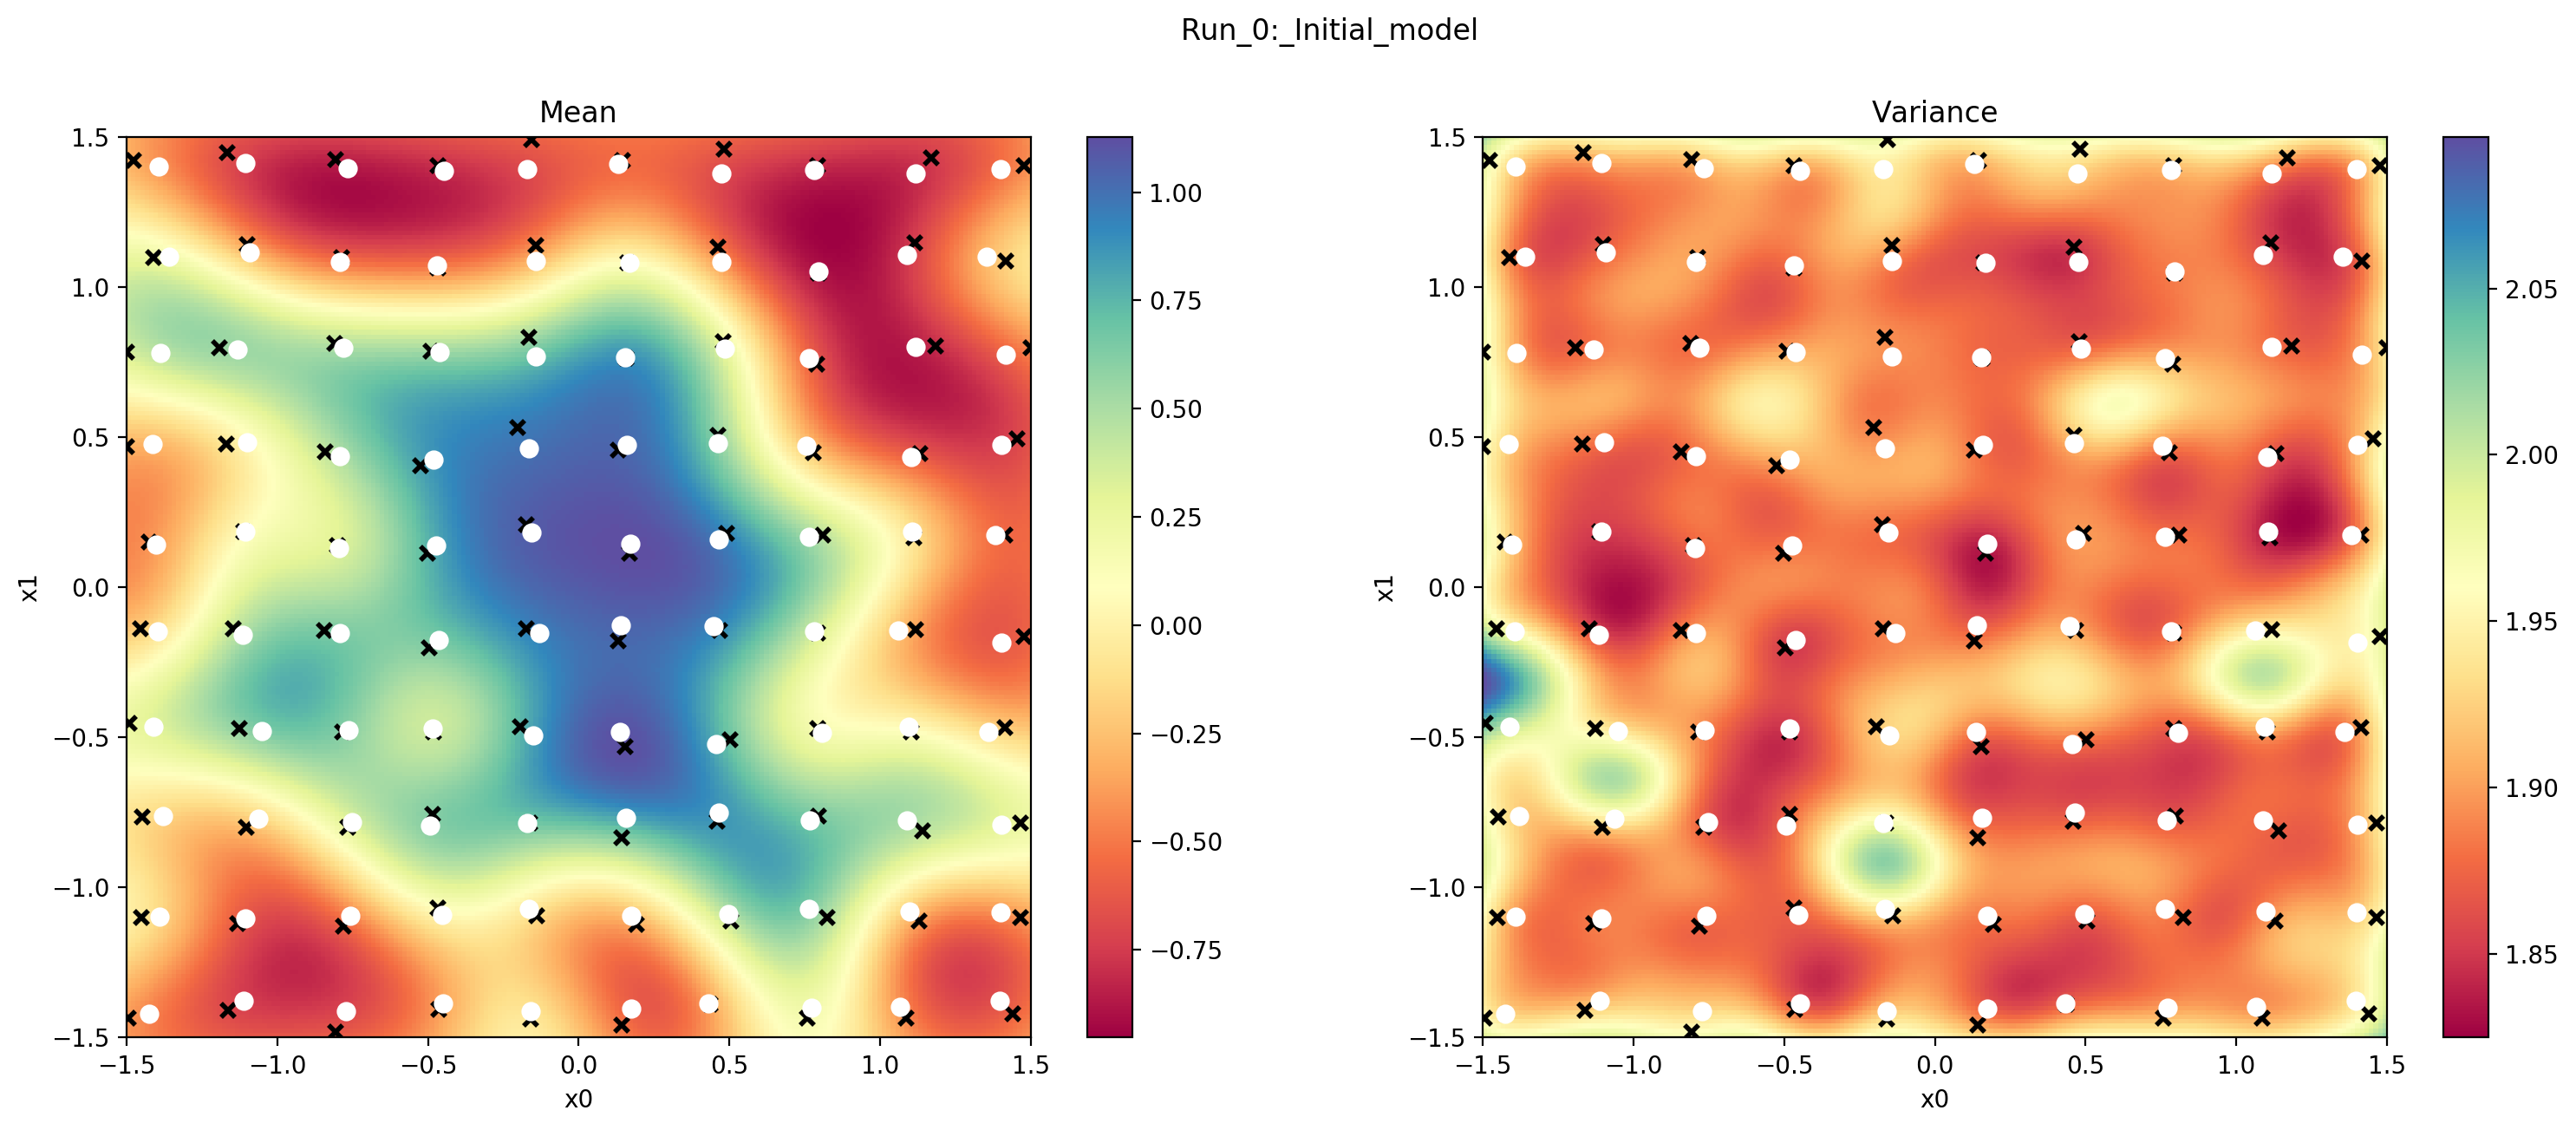

Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: -18056.727553961322
Loss at step 500: -72742.96623331221
Loss at step 1000: -73104.46789515717
Loss at step 1149: -73117.10675706071
tf.Tensor(
[[-0.92996548 -1.35816587]
 [-1.37533253  1.33917777]
 [ 0.60812442  1.03848428]
 [-1.3215746  -0.9554105 ]
 [ 1.44516405 -1.5       ]
 [ 0.93386981  1.5       ]
 [ 1.5        -1.5       ]
 [ 1.5        -1.31809726]
 [-1.36375594 -1.5       ]
 [-1.39774952 -1.5       ]
 [ 1.5         1.5       ]
 [ 1.38296058 -1.31097696]
 [ 1.30169925 -1.5       ]
 [ 0.51467709  1.34125645]
 [ 1.5        -0.46268322]
 [-0.73653096  1.5       ]
 [-0.24235144 -1.5       ]
 [-1.5         1.10555067]
 [-1.49199936  1.5       ]
 [ 1.5        -1.5       ]], shape=(20, 2), dtype=float64)
Evaluation 0: Calculating I
Evaluation 0: Next query is [[-1.33811222 -1.38183597]
 [-1.43695362  1.3055503 ]] with I value of 0.03543715313096418
Evaluation 0: Training model
Indifference_threshold is trainable

KeyboardInterrupt: 

In [35]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noiseless_observation(X, objective)
    
    inducing_variables = init_vals[run].reshape([-1, input_dims])
    inducing_variables += np.random.normal(0, 0.01, inducing_variables.shape)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, inducing_variables.shape[0], 
                                                               "Run_{}:_Initial_model".format(run),
                                                               inducing_variables)

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Sample possible next queries
        
        #samples = PBO.acquisitions.pes.sample_inputs(inputs, num_samples, num_choices, objective_low, objective_high)
        
        samples = np.random.uniform(low=objective_low,
                                   high=objective_high,
                                   size=[1000, num_choices, input_dims])
        
        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.fourier_features.sample_maximizers(X=inducing_vars,
                                                            count=num_maximizers,
                                                            n_init=10,
                                                            D=100,
                                                            model=model,
                                                            min_val=objective_low,
                                                            max_val=objective_high)
        print(maximizers)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noiseless_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        inducing_variables = np.concatenate([inducing_variables, 
                                             next_query + np.random.normal(0, 0.01)])
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   inducing_variables.shape[0], 
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation),
                                                                   inducing_variables)
        
        print_summary(model)
        
        
        # Save model
        pickle.dump((X, y, inputs, 
                     model.kernel.variance, 
                     model.kernel.lengthscale, 
                     model.likelihood.variance, 
                     inducing_vars, 
                     model.q_mu, 
                     model.q_sqrt, 
                     maximizers), 
                    open(results_dir + "Model_Run_{}_Evaluation_{}.p".format(run, evaluation), "wb"))
        
        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

In [760]:
x_data = uniform_grid(1, 10, low=0.01, high=0.99)
y_data = np.expand_dims(-PBO.objectives.forrester(x_data), axis=1)

In [761]:
m = gpflow.models.SVGP(
                     kernel=gpflow.kernels.RBF(lengthscale=0.1),
                     likelihood=gpflow.likelihoods.Gaussian(),
                     inducing_variable=uniform_grid(1, 10, low=0.01, high=0.99))
m.kernel.lengthscale.trainable = False

In [762]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(lambda: -m.log_likelihood((x_data, y_data)), m.trainable_variables)

      fun: 30.149634003463316
 hess_inv: <77x77 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.81887889e-03,  1.20638320e-03,  1.12754959e-03, -8.26037357e-04,
       -5.92810950e-03, -3.34360743e-03, -1.00084953e-02,  4.37334039e-04,
        2.72026218e-69, -7.67206035e-03, -7.98178596e-05,  5.60897770e-04,
        2.25399692e-04,  8.38976585e-04,  1.39405481e-04,  1.68951526e-04,
        1.02263105e-03, -5.21816401e-04, -1.68285306e-04,  4.62744649e-04,
       -8.37669141e-04, -3.07893287e-05, -7.13894099e-04, -4.61804950e-05,
        5.57793967e-05, -4.60641213e-04, -1.42144893e-04,  2.98073021e-04,
       -4.16028200e-05, -2.04788860e-05,  3.19297987e-05,  2.58428895e-04,
       -4.92608708e-04,  5.20923113e-04, -3.13139083e-05, -1.61219837e-06,
        3.52091264e-07,  6.03081015e-08, -7.58391762e-11, -6.47853810e-10,
        5.23224049e-10, -3.53605204e-09, -3.22558719e-04,  2.22644099e-04,
       -1.28822240e-04,  2.20561534e-05, -3.52748001e-05,  4.09903367e-05,
 

In [763]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,27.94034874602659
SVGP.kernel.lengthscale,Parameter,Softplus,,False,(),float64,0.10000000000000007
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,3.2221755200343125
SVGP.inducing_variable.Z,Parameter,,,True,"(10, 1)",float64,[[0.12623383...
SVGP.q_mu,Parameter,,,True,"(10, 1)",float64,[[1.22071686e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[3.01987962e-01, 0.00000000e+00, 0.00000000e+00..."


(-0.0, 1.0)

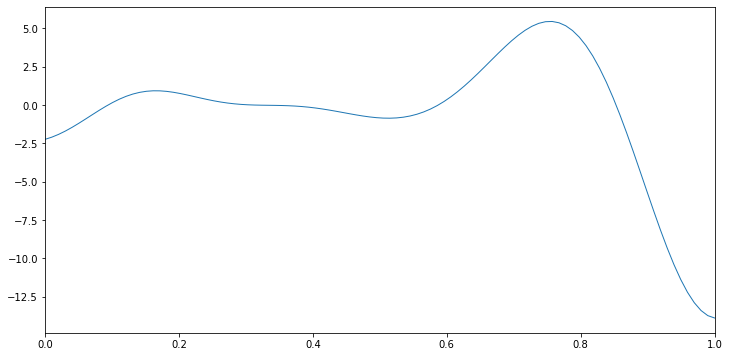

In [764]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, m.predict_f(xx)[0], 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [765]:
sample_maximizers_simple(m, 100, 1000, 1, 0., 1.)

array([[0.73772947],
       [0.78178448],
       [0.76427863],
       [0.72679862],
       [0.73948874],
       [0.74356915],
       [0.68840351],
       [0.73352333],
       [0.66122372],
       [0.72902812],
       [0.73462639],
       [0.75688467],
       [0.7715411 ],
       [0.77346086],
       [0.79442434],
       [0.73239587],
       [0.73576929],
       [0.7677551 ],
       [0.76277775],
       [0.76133143],
       [0.75355837],
       [0.75541682],
       [0.74169334],
       [0.7513498 ],
       [0.77374059],
       [0.73792443],
       [0.76199393],
       [0.70753178],
       [0.74612907],
       [0.75801449],
       [0.75431371],
       [0.77854945],
       [0.75613726],
       [0.700947  ],
       [0.76535593],
       [0.75967957],
       [0.73100334],
       [0.73033663],
       [0.76461393],
       [0.7749658 ],
       [0.75675794],
       [0.72922034],
       [0.78327098],
       [0.7621285 ],
       [0.76771332],
       [0.64101121],
       [0.7359751 ],
       [0.740

In [766]:
maximizers = sample_maximizers(X=m.inducing_variable.Z.numpy(),
                                                    count=100,
                                                    n_init=100,
                                                    D=100,
                                                    model=m,
                                                    min_val=0.,
                                                    max_val=1.)

Loss at step 0: 1477.2781143332386
Loss at step 500: -6814.3199738223375
Loss at step 828: -6819.79306044409


In [767]:
maximizers

<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
array([[0.74895951],
       [0.74291084],
       [0.64700422],
       [0.72004768],
       [0.72971487],
       [0.59860233],
       [0.75057575],
       [0.68407596],
       [0.73119555],
       [0.74525845],
       [0.69343222],
       [0.73730554],
       [0.78155251],
       [0.74272491],
       [0.76120239],
       [0.76285951],
       [0.76183298],
       [0.75515535],
       [0.67629405],
       [0.73801144],
       [0.7033778 ],
       [0.73498019],
       [0.76268906],
       [0.72222781],
       [0.7464153 ],
       [0.6749697 ],
       [0.69598659],
       [0.75241866],
       [0.67196171],
       [0.73549147],
       [0.67468399],
       [0.66161195],
       [0.66439939],
       [0.62912069],
       [0.67139755],
       [0.75913539],
       [0.66200744],
       [0.72954809],
       [0.72431483],
       [0.67309086],
       [0.14387807],
       [0.75447558],
       [0.        ],
       [0.72697688],
       [0.66041063],
     

In [768]:
test = np.array([[0.1],
                 [0.3],
                [0.5]])

In [769]:
m.kernel.K(test)

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[2.79403487e+01, 3.78131501e+00, 9.37294281e-03],
       [3.78131501e+00, 2.79403487e+01, 3.78131501e+00],
       [9.37294281e-03, 3.78131501e+00, 2.79403487e+01]])>

In [803]:
total = np.zeros((1,3,3))
for i in range(100):
    phi, W, b, theta = sample_features_weights(np.expand_dims(m.inducing_variable.Z.numpy(), axis=0), m, 100)
    total += fourier_features(np.expand_dims(test, axis=0), W, b, m.kernel.variance) @ tf.linalg.matrix_transpose(fourier_features(np.expand_dims(test, axis=0), W, b, m.kernel.variance))
print(total/100)

tf.Tensor(
[[[27.4715471   3.74795236 -0.07732147]
  [ 3.74795236 27.81980763  3.82976713]
  [-0.07732147  3.82976713 28.03453379]]], shape=(1, 3, 3), dtype=float64)


In [822]:
x_data = uniform_grid(input_dims, 10, low=objective_low+0.1, high=objective_high-0.1)
#x_data = np.random.uniform(low=-0.5, high=0.5, size=(20, 2))
y_data = np.expand_dims(-objective(x_data), axis=1) + 7

#y_data = np.array([2, 1.5, 1, 1, 2, 2, 1.5, 1, 1, 2, 2, 1.5, 1, 1, 2, 2, 1.5, 1, 1, 2])

In [823]:
m1 = gpflow.models.SVGP(
                     kernel=gpflow.kernels.RBF(lengthscale=0.3),
                     likelihood=gpflow.likelihoods.Gaussian(),
                     inducing_variable=x_data)

In [824]:
optimizer = gpflow.optimizers.Scipy()

In [825]:
optimizer.minimize(lambda: -m1.log_likelihood((x_data, y_data)), m1.trainable_variables)

      fun: 68.59355476687787
 hess_inv: <5353x5353 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 21.95947312, -17.07140164,   3.55376797, ...,  -0.45986881,
         0.05801014,   1.32485444])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 15001
      nit: 13978
   status: 1
  success: False
        x: array([-0.79605266, -1.30041132, -1.08115232, ...,  0.03658143,
        0.35242949,  0.12520039])

In [827]:
print_summary(m1)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,29.333972924704447
SVGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.7549926764570646
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0036688908192929652
SVGP.inducing_variable.Z,Parameter,,,True,"(100, 2)",float64,"[[-0.79605266, -1.30041132..."
SVGP.q_mu,Parameter,,,True,"(100, 1)",float64,[[-0.12024401...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[8.49670370e-03, 0.00000000e+00, 0.00000000e+00..."


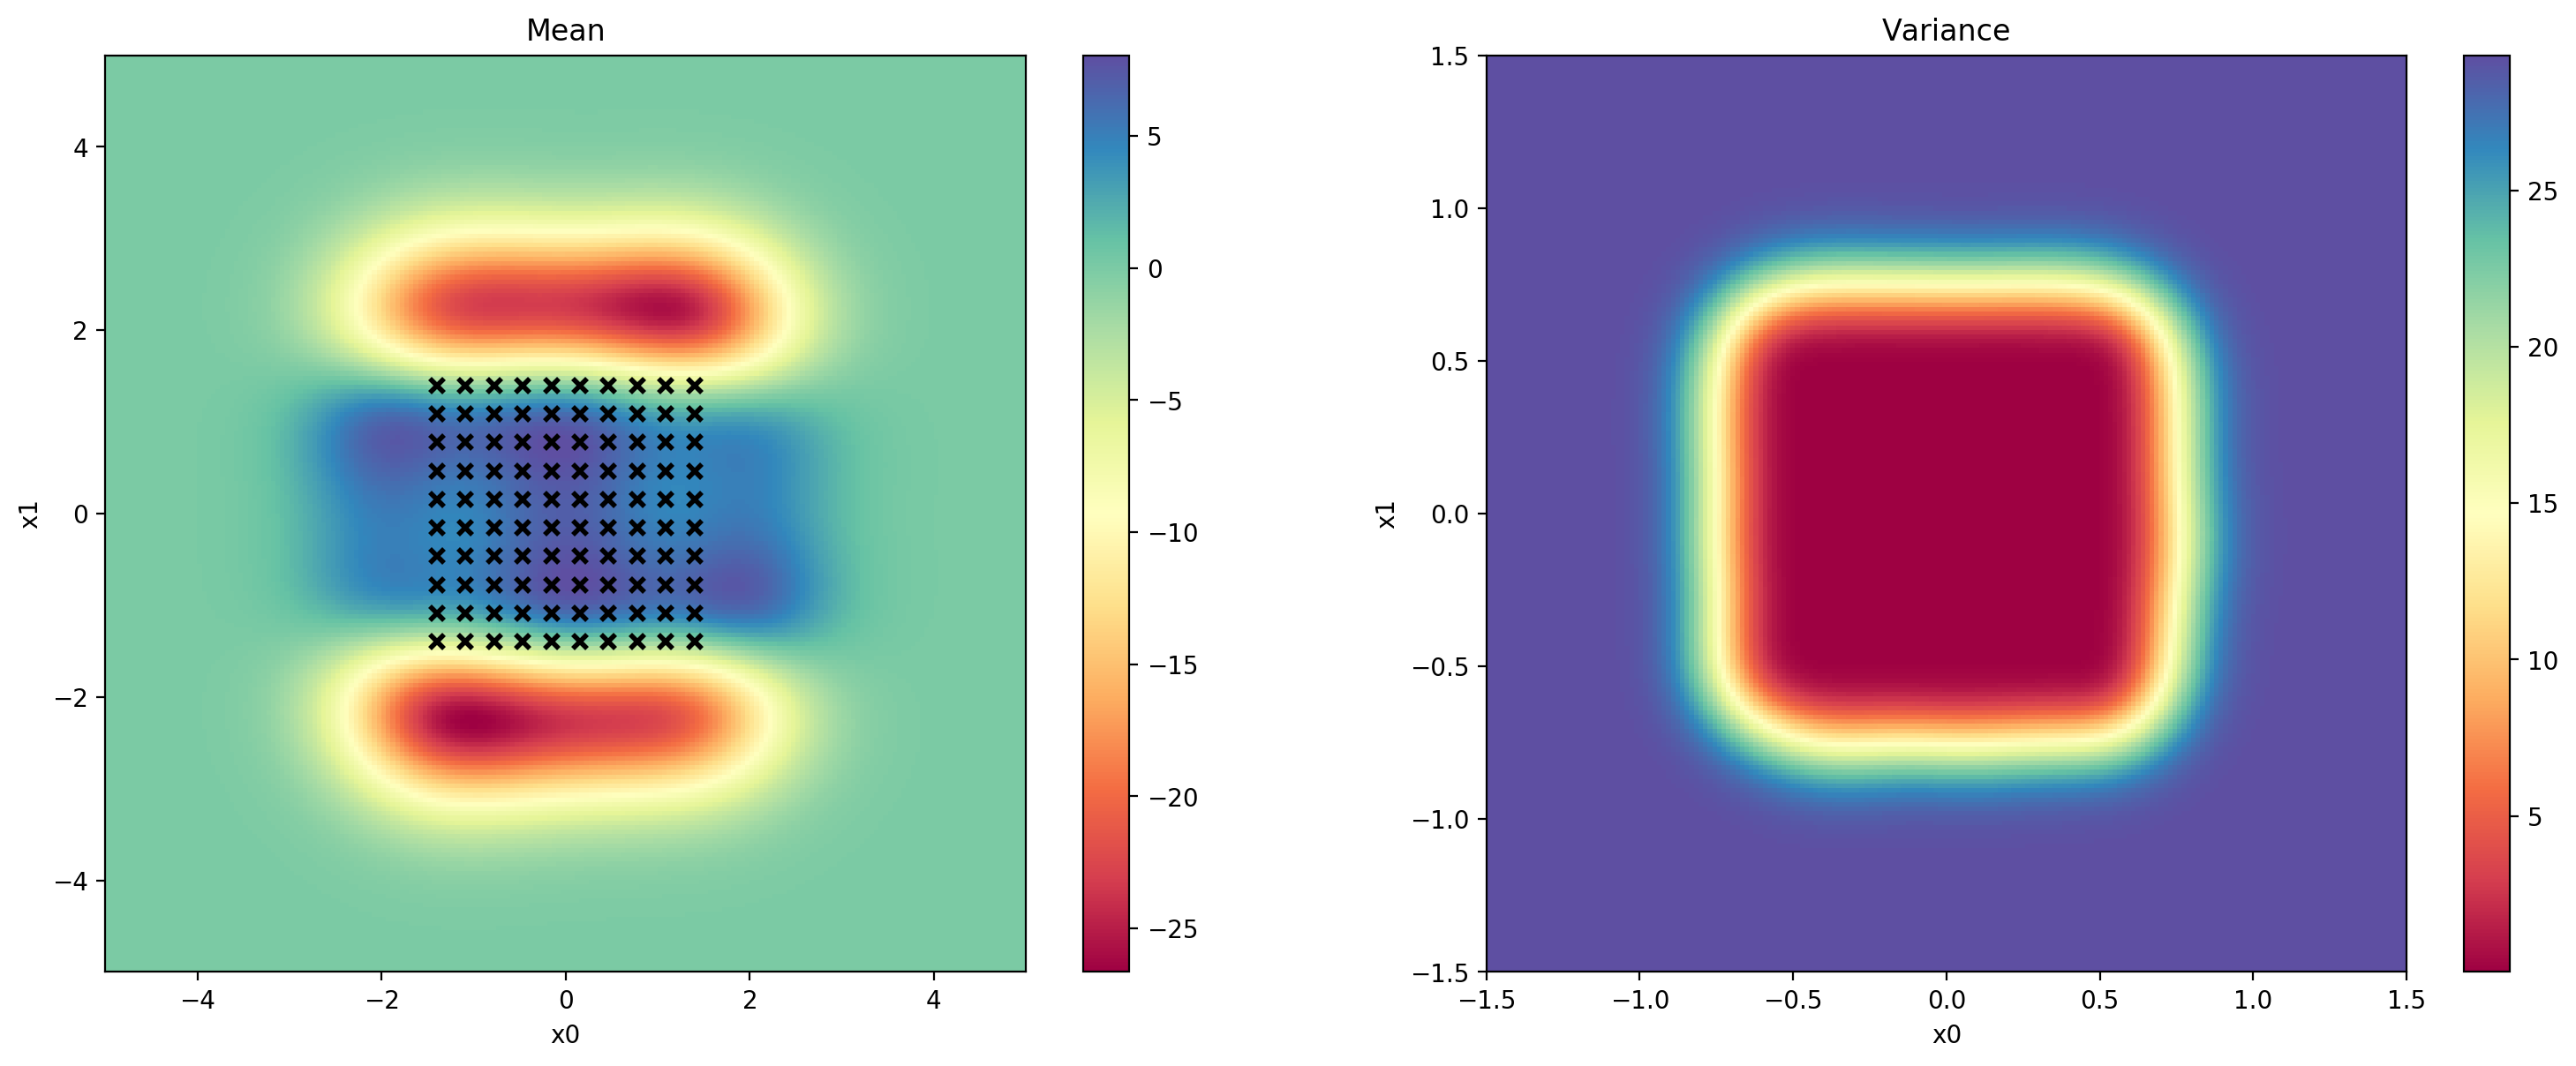

In [836]:
cmap = 'Spectral'
#side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
side = np.linspace(-5., 5., num_discrete_per_dim)
combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
predictions = m1.predict_y(combs)
preds = tf.transpose(tf.reshape(predictions[0], [num_discrete_per_dim, num_discrete_per_dim]))
variances = tf.transpose(tf.reshape(predictions[1], [num_discrete_per_dim, num_discrete_per_dim]))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6.88)
fig.set_dpi((200))

ax1.axis('equal')
im1 = ax1.imshow(preds, 
                 interpolation='nearest', 
                 #extent=(objective_low, objective_high, objective_low, objective_high), 
                 extent=(-5., 5., -5., 5.), 
                 origin='lower', 
                 cmap=cmap)
ax1.plot(x_data[:, 0], x_data[:, 1], 'kx', mew=2)

ax1.set_title("Mean")
ax1.set_xlabel("x0")
ax1.set_ylabel("x1")
fig.colorbar(im1, ax=ax1)

ax2.axis('equal')
im2 = ax2.imshow(variances, 
                 interpolation='nearest', 
                 extent=(objective_low, objective_high, objective_low, objective_high), 
                 origin='lower', 
                 cmap=cmap)
ax2.set_title("Variance")
ax2.set_xlabel("x0")
ax2.set_ylabel("x1")
fig.colorbar(im2, ax=ax2)

In [829]:
test = np.array([[0.1, 0.3],
                 [0.3, 0.4],
                [0.5, 0.19]])

In [830]:
m1.kernel.K(test)

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[29.33397292, 28.0752317 , 25.22372727],
       [28.0752317 , 29.33397292, 27.2478932 ],
       [25.22372727, 27.2478932 , 29.33397292]])>

In [831]:
total = np.zeros((1,3,3))
for i in range(100):
    phi, W, b, theta = sample_features_weights(np.expand_dims(m1.inducing_variable.Z.numpy(), axis=0), m1, 100)
    total += fourier_features(np.expand_dims(test, axis=0), W, b, m1.kernel.variance) @ tf.linalg.matrix_transpose(fourier_features(np.expand_dims(test, axis=0), W, b, m1.kernel.variance))
print(total/100)

tf.Tensor(
[[[29.63989698 28.40357459 25.51631447]
  [28.40357459 29.5817546  27.38869321]
  [25.51631447 27.38869321 29.31243579]]], shape=(1, 3, 3), dtype=float64)


In [832]:
maximizers = sample_maximizers(X=m1.inducing_variable.Z.numpy(),
                                                    count=50,
                                                    n_init=50,
                                                    D=2000,
                                                    model=m1,
                                                    min_val=objective_low,
                                                    max_val=objective_high)

Loss at step 0: -232661899.22243696
Loss at step 500: -660515818.2579968
Loss at step 1000: -962056139.0973899
Loss at step 1500: -1094940092.3952878
Loss at step 2000: -1120742360.3978255
Loss at step 2500: -1123700593.1675763


In [845]:
maximizers = sample_maximizers_simple(m1, 100, 20, 2, objective_low, objective_high)

In [846]:
maximizers

array([[-0.24457779,  0.59958271],
       [ 0.10513666, -0.89025385],
       [ 0.22488543, -0.80243037],
       [-0.11051532,  0.30118858],
       [ 0.17306811, -0.55675351],
       [-0.04240193, -0.77035429],
       [-0.05128651, -0.32815812],
       [ 0.35660081, -0.3680287 ],
       [ 0.08155614, -0.66014917],
       [-0.16901145,  0.73766686],
       [ 0.09436875, -0.74100916],
       [-0.31243758,  0.7130515 ],
       [-0.0039705 , -0.78554385],
       [-0.14556856,  0.8462698 ],
       [ 0.08732479,  0.556947  ],
       [ 0.24203241, -0.78742571],
       [-0.40994926,  0.63475502],
       [-0.09441475, -0.82235735],
       [-0.07177338,  0.39390589],
       [ 0.44528546, -0.65126194],
       [-0.04758759,  0.70478142],
       [-0.58993848,  0.85823553],
       [-0.14392035, -0.65597019],
       [-0.61302101,  0.82689085],
       [-0.1019037 ,  0.36103614],
       [-0.28845988,  0.50270895],
       [-0.39897987, -0.62875326],
       [ 0.06072923,  0.8890949 ],
       [ 0.33381905,

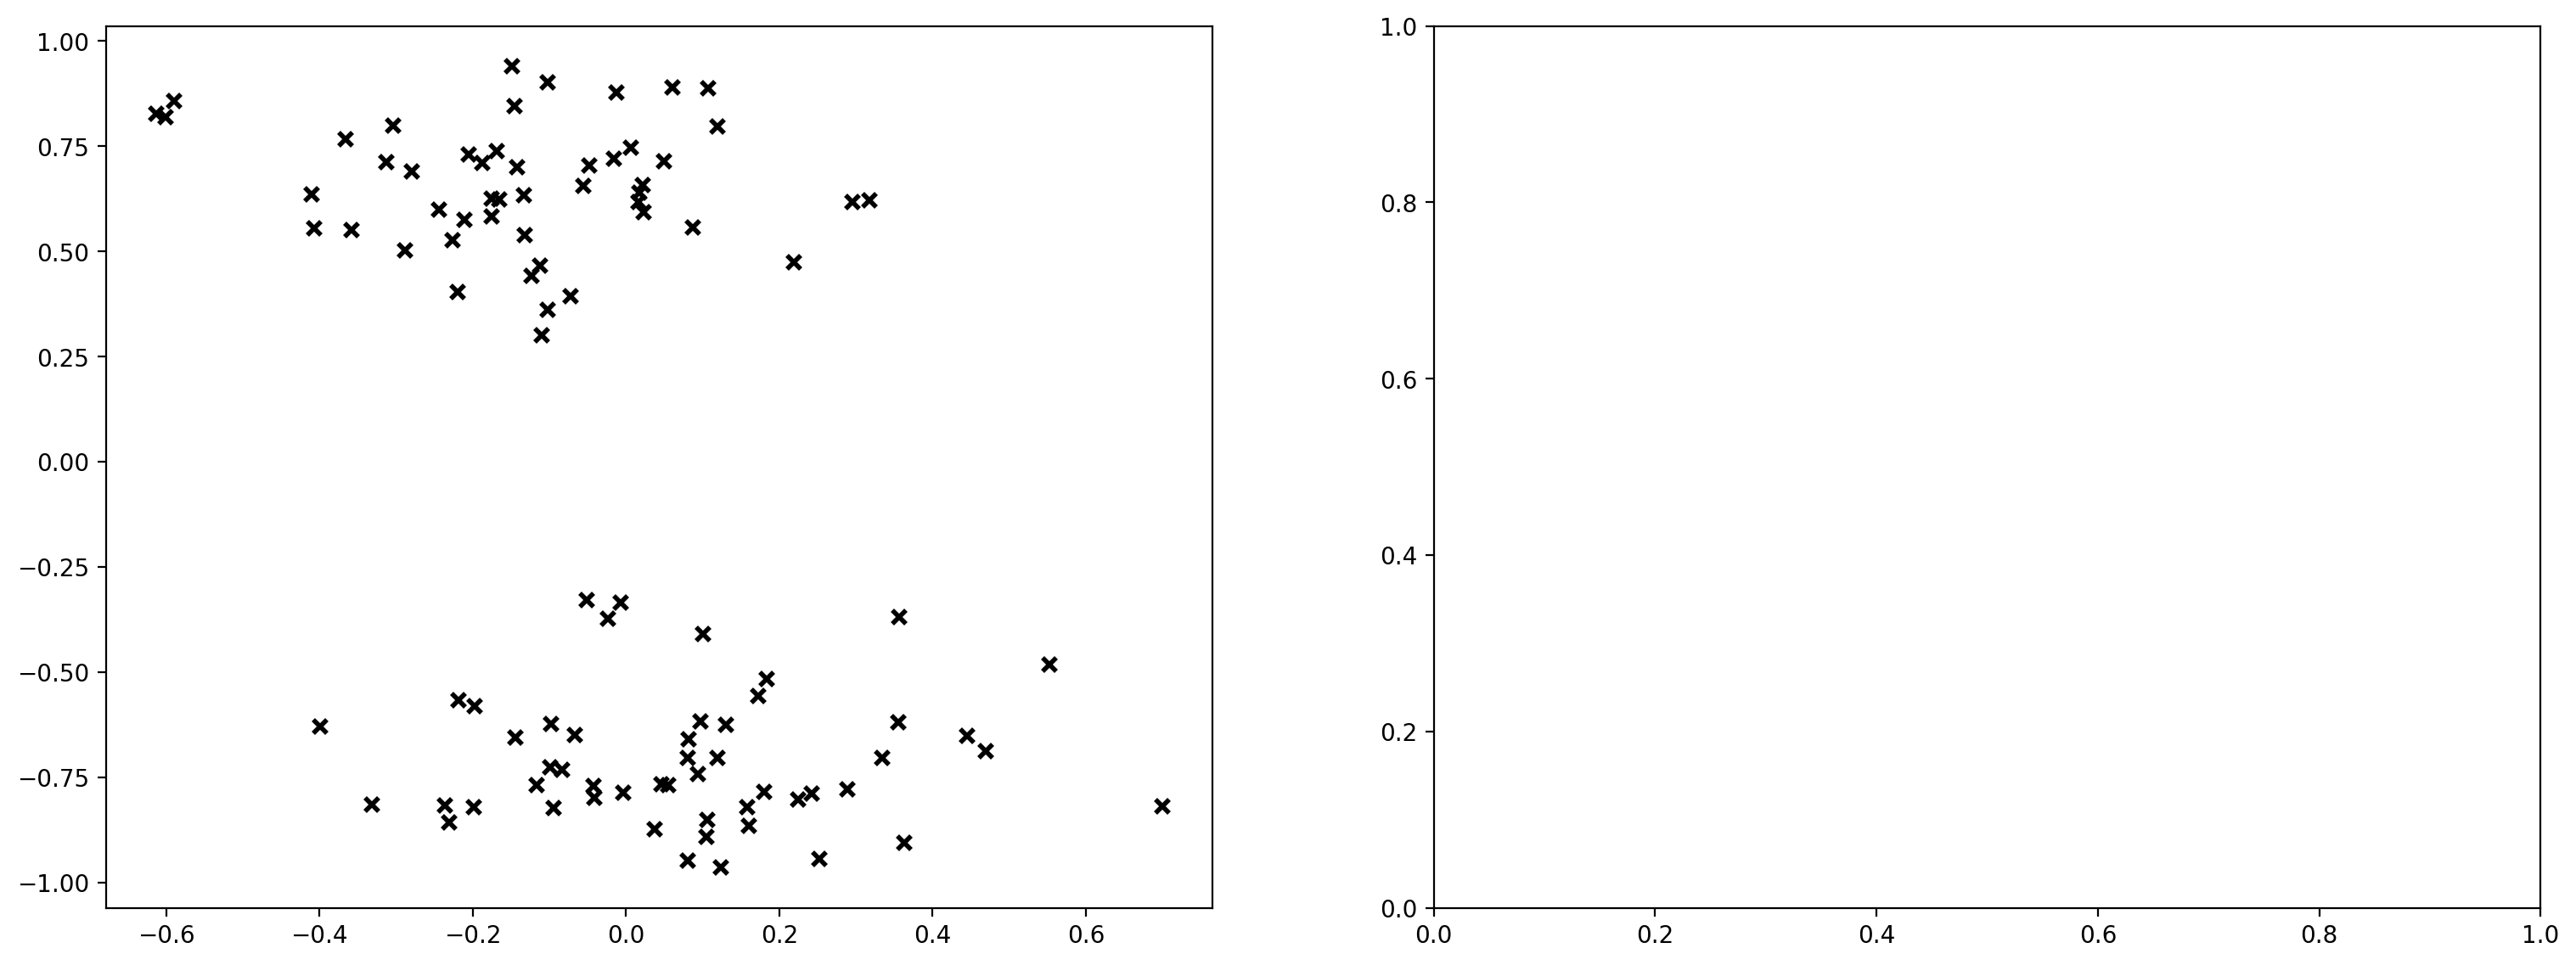

In [847]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6.88)
fig.set_dpi((200))
ax1.plot(maximizers[:, 0], maximizers[:, 1], 'kx', mew=2)


In [838]:
def sample_maximizers_simple(model, num_maximizers, num_samples, input_dims, low, high):
    maximizers = np.zeros((num_maximizers, input_dims))
    for i in range(num_maximizers):
        xx = np.random.uniform(low, high, (num_samples, input_dims))
        samples = np.squeeze(model.predict_f_samples(xx, 1))  # (num_maximizers)
        samples_argmax = np.argmax(samples)
        maximizers[i] = xx[samples_argmax]
    return maximizers

In [701]:
samples = np.squeeze(m1.predict_f_samples(xx, 1))

In [702]:
samples_argmax = np.argmax(samples)

In [703]:
samples_argmax

386

In [694]:
xx[386]

array([ 0.10080791, -0.72051276])

In [690]:
np.expand_dims(np.take(xx, samples_argmax), axis=1)

array([[-0.08085347],
       [-0.08085347],
       [-0.08085347],
       [-0.08085347],
       [ 0.74676392],
       [ 0.74676392],
       [ 0.74676392],
       [-0.08085347],
       [ 0.74676392],
       [-0.08085347]])

In [730]:
sample_maximizers_simple(m, 100, 1000, 1, 0., 1.)

array([[0.7568435 ],
       [0.75446955],
       [0.75668057],
       [0.75629835],
       [0.75367103],
       [0.7581086 ],
       [0.75678075],
       [0.75242588],
       [0.75614147],
       [0.75390424],
       [0.75501747],
       [0.75550201],
       [0.75757166],
       [0.75342228],
       [0.75398444],
       [0.75646504],
       [0.75630752],
       [0.75357347],
       [0.75442901],
       [0.7541491 ],
       [0.75516683],
       [0.75591391],
       [0.75662979],
       [0.75593929],
       [0.75930424],
       [0.75710526],
       [0.75644109],
       [0.75547531],
       [0.75847874],
       [0.75509292],
       [0.75443216],
       [0.75634793],
       [0.75681159],
       [0.75563988],
       [0.75547141],
       [0.75370981],
       [0.75575961],
       [0.76005879],
       [0.76003039],
       [0.75463948],
       [0.75556241],
       [0.75424109],
       [0.75387384],
       [0.75655537],
       [0.7548401 ],
       [0.75224841],
       [0.75310401],
       [0.759

In [709]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,50.068715209428994
SVGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.1575784389509765
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0019737023227290483
SVGP.inducing_variable.Z,Parameter,,,True,"(10, 1)",float64,[[0.11887309...
SVGP.q_mu,Parameter,,,True,"(10, 1)",float64,[[0.12557635...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[0.00627282, 0., 0...."


In [280]:
maximizers = sample_maximizers(X=m1.inducing_variable.Z.numpy(),
                                                            count=100,
                                                            n_init=10,
                                                            D=100,
                                                            model=m1,
                                                            min_val=objective_low,
                                                            max_val=objective_high)

Loss at step 0: -1476.7833315374392
Loss at step 500: -2474.68018048683
Loss at step 1000: -3268.9841095690426
Loss at step 1500: -3846.2446931479662
Loss at step 2000: -4200.430246743361
Loss at step 2500: -4383.907032846575
tf.Tensor(
[[ 6.77090828e+00  6.75241110e+00  6.77090828e+00  6.77090828e+00
   6.77090828e+00  6.77090828e+00  6.77090828e+00  6.77090828e+00
   6.75943074e+00  6.77090828e+00]
 [-1.00858221e+00 -1.01256664e+00 -1.00858221e+00 -1.00858221e+00
  -1.00858221e+00 -1.00858221e+00 -1.00858221e+00 -1.00858221e+00
  -1.00858221e+00 -1.00858221e+00]
 [ 1.42505195e+00  1.42505195e+00  1.42505195e+00  1.42505195e+00
   1.42505195e+00  1.42505195e+00  1.42505195e+00  1.42505195e+00
   1.42505195e+00  1.42505195e+00]
 [-8.57793911e-01 -8.15879179e-01 -8.15879179e-01 -8.57793911e-01
  -8.15879179e-01 -8.57793911e-01 -8.75751534e-01 -8.57793911e-01
  -8.71126765e-01 -8.57793911e-01]
 [ 1.12195003e+00  1.11734566e+00  1.12195249e+00  1.12195218e+00
   1.15654607e+00  1.12195259

In [281]:
maximizers

<tf.Tensor: shape=(100, 2), dtype=float64, numpy=
array([[-1.5       , -1.5       ],
       [ 1.5       , -1.5       ],
       [ 1.5       ,  1.5       ],
       [-1.5       ,  1.5       ],
       [-1.5       , -1.5       ],
       [ 1.5       ,  1.5       ],
       [ 1.5       ,  1.5       ],
       [-1.5       ,  1.5       ],
       [ 1.5       , -1.5       ],
       [-1.5       , -1.5       ],
       [-1.5       , -1.5       ],
       [ 1.5       , -1.5       ],
       [-1.5       ,  1.5       ],
       [ 1.5       ,  1.5       ],
       [ 1.5       ,  1.5       ],
       [-1.5       , -1.5       ],
       [-1.5       ,  1.5       ],
       [ 1.5       ,  1.5       ],
       [ 1.5       ,  1.22945662],
       [-1.5       , -1.5       ],
       [ 1.5       ,  1.5       ],
       [ 1.5       , -1.5       ],
       [-1.5       ,  1.5       ],
       [-1.5       ,  1.5       ],
       [ 1.5       , -1.5       ],
       [ 1.5       ,  1.5       ],
       [ 1.5       ,  1.5       ],
     

In [754]:
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp


def fourier_features(X, W, b, alpha):
    """
    Given sampled tensors W and b, construct Fourier features of X.
    :param X: tensor of shape (count, n, d)
    :param W: tensor of shape (count, D, d)
    :param b: tensor of shape (count, D, 1)
    :param alpha: normalizing constant
    :return: tensor of shape (count, n, D)
    """
    D = W.shape[1]

    WX_b = W @ tf.linalg.matrix_transpose(X) + b  # (count, D, n)
    return tf.cast(tf.sqrt(2.0 * alpha / D), dtype=tf.float64) * tf.cos(tf.linalg.matrix_transpose(WX_b))  # (count, n, D)


def sample_fourier_features(X, kernel, D=100):
    """
    Fourier feature mapping of X for the RBF kernel
    :param X: tensor of shape (count, n, d)
    :return: tensor of shape (count, n, D)
    """
    count = X.shape[0]
    d = X.shape[2]


    lengthscales = kernel.lengthscale.numpy()

    W = tf.random.normal(shape=(count, D, d),
                         mean=0.0,
                         stddev=1.0 / lengthscales,
                         dtype=tf.float64)
    b = tf.random.uniform(shape=(count, D, 1),
                          minval=0,
                          maxval=2 * np.pi,
                          dtype=tf.float64)

    return fourier_features(X, W, b, kernel.variance.numpy()), W, b  # (count, n, D)


def sample_theta_variational(phi, q_mu, q_sqrt):
    """
    Samples from distribution q(theta|D) = /int p(theta|y)p(y|f)q(f|D) df dy
    :param phi: Fourier features tensor with shape (count, n, D)
    :param q_mu: tensor of shape (n, 1)
    :param q_sqrt: tensor of shape (1, n, n). Lower triangular matrix
    :return: tensor with shape (count, D, 1)
    """
    count = phi.shape[0]
    n = phi.shape[1]
    D = phi.shape[2]

    standard_normal = tfp.distributions.MultivariateNormalDiag(
            loc=tf.zeros(n, dtype=tf.float64), 
            scale_diag=tf.ones(n, dtype=tf.float64))
    standard_normal_samples = standard_normal.sample(count)
    # (count, n)

    q_samples = q_sqrt @ tf.expand_dims(standard_normal_samples, axis=-1) + q_mu
    # (count,n,1)

    transposed_phi = tf.linalg.matrix_transpose(phi)
    # (count, D, n)

    transform_mat = tf.cond(n >= D,
        true_fn = lambda : tf.linalg.inv(transposed_phi @ phi) @ transposed_phi,
        false_fn = lambda: transposed_phi @ tf.linalg.inv(phi @ transposed_phi) ) # (count, D, n)

    theta = transform_mat @ q_samples
    # (count, D, 1)

    return theta


def sample_features_weights(X, model, D):
    # Ensure phi @ transposed_phi is invertible
    invertible = False
    fail_count = 0
    while not invertible:
        try:
            phi, W, b = sample_fourier_features(X, model.kernel, D)  # phi has shape (count, n, D)
            theta = sample_theta_variational(phi, model.q_mu, model.q_sqrt)
            invertible = True
        except tf.errors.InvalidArgumentError as err:  # this will be thrown if matrix inversion fails
            print(err)
            print("Resampling phi, W, b, theta")
            fail_count += 1
        if fail_count >= 100:
            print("Retry limit exceeded")
            raise ValueError("Failed")

    return phi, W, b, theta


def sample_maximizers(X, count, n_init, D, model, min_val, max_val, num_steps=3000):
    """
    Samples from the posterior over the global maximizer using the method by Shah & Ghahramani (2015). Approximates
    the RBF kernel with its Fourier dual. Samples random Fourier features, constructs a linear model and computes
    the argmax using gradient-based optimization.

    :param X: input points, tensor with shape (n, d)
    :param count: number of maximizers to sample. Each will be taken from one separate function sample
    :param n_init: Number of initializing points for each function sample. This method will take the argmax of all
    initializing points after optimization, so that each function sample will have one maximizer returned
    :param D: number of Fourier features to use
    :param model: gpflow model that uses the RBF kernel and has been optimized
    :param min_val: float, min value that a maximizer can take
    :param max_val: float, max value that a maximizer can take
    :param num_steps: int that specifies how many optimization steps to take
    :return: tensor of shape (count, d)
    """
    d = X.shape[1]

    X = tf.tile(tf.expand_dims(X, axis=0), [count, 1, 1])  # (count, n, d)

    phi, W, b, theta = sample_features_weights(X, model, D)

    def construct_maximizer_objective(x_star):
        g = tf.reduce_sum(fourier_features(x_star, W, b, model.kernel.variance) @ theta)
        return -g

    # Compute x_star using gradient based methods
    optimizer = tf.keras.optimizers.Adam()
    x_star = tf.Variable(tf.random.uniform(shape=(count, n_init, d),
                                           minval=min_val,
                                           maxval=max_val,
                                           dtype=tf.dtypes.float64),
                         constraint=lambda x: tf.clip_by_value(x, min_val, max_val))
    loss = lambda: construct_maximizer_objective(x_star)

    prev_loss = loss().numpy()
    for i in range(num_steps):
        optimizer.minimize(loss, var_list=[x_star])
        current_loss = loss().numpy()
        if i % 500 == 0:
            print('Loss at step %s: %s' % (i, current_loss))
        if abs((current_loss-prev_loss) / prev_loss) < 1e-7:
            print('Loss at step %s: %s' % (i, current_loss))
            break
        prev_loss = current_loss

    fvals = tf.reduce_sum(fourier_features(x_star, W, b, model.kernel.variance) @ theta, axis=-1)
    # (count, n_init)
    max_idxs = tf.transpose(tf.stack([tf.range(count, dtype=tf.int64), 
                         tf.math.argmax(fvals, axis=1)]))
    maximizers = tf.gather_nd(x_star, 
                indices=max_idxs)

    return maximizers


In [647]:
k.lengthscale.numpy()

1.2499999999999998

In [648]:
k.lengthscale

<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=0.9124204349125888 constrained-shape=() constrained-value=1.2499999999999998>

In [290]:
k = gpflow.kernels.RBF(lengthscale=1.25)

In [292]:
k.K([[0.1], [0.2]])

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[1.        , 0.99680511],
       [0.99680511, 1.        ]])>

In [295]:
np.exp(-0.5 * (1./(k.lengthscale.numpy() * k.lengthscale.numpy())) * (0.1*0.1))

0.9968051145430329

In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()

In [ ]:
np.mean(PBO.objectives.six_hump_camel(best_guess_results), axis=0)

In [ ]:
fourier_features.py